# Integrating quantum kernels into scikit-learn

This notebook provides a didactic template to use *scikit-learn*'s **support vector machine** in combination with a **quantum kernel**. The quantum kernel is a dummy function that you can fill with life yourself!

## Important Disclaimer
This notebook is adapted from the guest lectures of this course [QML](https://www.edx.org/course/quantum-machine-learning-2) by Prof Peter Wittek


I tried to implement the implicit approach of this paper [paper](https://arxiv.org/abs/1803.07128) By Maria Schuld & Nathan Killoran. 

In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numba import jit # I used numba to accelerate nested for in the kernel function
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

### Preliminaries

The quantum kernel -- as any other real-valued kernel -- is a function that takes two data inputs x1 and x2 and maps them to a real number. Here we always return zero to use the function as a dummy or placeholder.

In [4]:

def kernel(x1, x2,amp):
    
    a = np.array((1/np.cosh(amp)) * (1/np.cosh(amp)))
#    print('a= ', a)        
    b = 1 - (np.exp(1j*(x2-x1)) * np.tanh(amp) * np.tanh(amp))   
 #   print('b= ', b)
  #  print("sqrt ",np.sqrt(a/b))
    return abs(np.dot(np.sqrt(a/b).T.conj(),np.sqrt(a/b)))

Scikit-learn's Support Vector Machine estimator takes kernel Gram matrices. We therefore create a function that, given two lists of data points A and B, computes the Gram matrix whose entries are the pairwise kernels

In [5]:
def gram(A, B,amp):
    gram = np.zeros((len(A), len(B)))
    for id1, x1 in enumerate(A):
#        print(id1,x1)
        for id2, x2 in enumerate(B):
            temp = kernel(x1, x2,amp)
#            print('value = ', temp)
            gram[id1, id2] = temp
 #           print("index_1: ",id1," index_1: ",id2)
  #          print("vectors: ",x1," ",x2)
    return gram

Let's look at an example where we feed one list of data points into both slots. Of course, our dummy kernel returns only zeros.

In [6]:
data = np.array([[1, 2], [3, 4]])
#print(data.shape)
gram(data, data,.5)

array([[2.        , 1.42208574],
       [1.42208574, 2.        ]])

Another example constructs rectangular gram matrices from two data lists of different length. This will be useful for new predictions.

In [7]:
data1 = np.array([[1, 2], [3, 4]])
data2 = np.array([[2, 4]])

gram(data1, data2,1.5)

array([[0.32164075],
       [1.20383927]])

### Data preparation

Let's load the good old Iris dataset and split it into training and test set or any dataset you want to play with

In [32]:
X,y = make_circles(n_samples=400,random_state=1,noise=0.20,factor=0.05)
X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size=0.2,random_state=0)
X_train.shape,Y_train[2]

((320, 2), 1)

If you have matplotlib installed, you can plot the first of four dimensions.

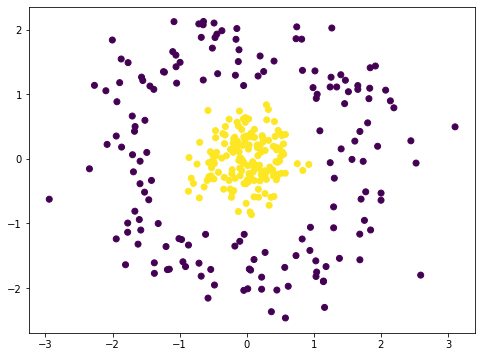

In [33]:
# preprocessing the data
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(2, figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
plt.show()

To prepare the data for the SVM with custom kernel, we have to compute two different Gram matrices for the iris datasets. The "training Gram matrix" computes kernels on pairwise entries of the training set, while the "test Gram matrix" combines training and test set.

In [34]:
gram_train = gram(X_train, X_train,1.)
gram_test = gram(X_test, X_train,1.)

### Training

Now we can train a Support Vector Machine and, for example, compute the accuracy on the test set. We have to select the 'precomputed' option to feed custom kernels. 

The fitting function takes the "training gram matrix". To make predictions on the test set using the trained model, we have to feed it the "test Gram matrix".

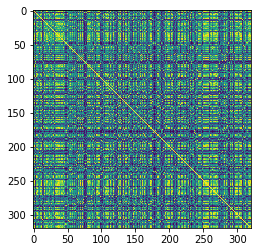

In [35]:

plt.imshow(gram_train,interpolation='nearest',origin='upper')


In [40]:
svm = SVC(C=1.0,kernel='precomputed',random_state=0)
svm.fit(gram_train, Y_train)
print("training score = ", svm.score(gram_train,Y_train))
scores = cross_val_score(X=gram_train,y=Y_train,estimator=svm,cv=10,n_jobs=4)
print("validation accuracy of the estimator = ", scores.mean())
predictions_test = svm.predict(gram_test)
print('testing accuracy = ', accuracy_score(predictions_test, Y_test))

training score =  1.0
validation accuracy of the estimator =  1.0
testing accuracy =  1.0


Classical SVM with RBF kernel

In [37]:
classical_svm = SVC(C=1.0,kernel='rbf',random_state=0)
classical_svm.fit(X_train, Y_train)
print("training score = ", classical_svm.score(X_train,Y_train))
scores = cross_val_score(X=X_train,y=Y_train,estimator=classical_svm,cv=10,n_jobs=4)
print("validation accuracy of the estimator = ", scores.mean())
predictions_test = classical_svm.predict(X_test)
print('testing accuracy = ', accuracy_score(predictions_test, Y_test))

training score =  1.0
validation accuracy of the estimator =  1.0
testing accuracy =  0.9875


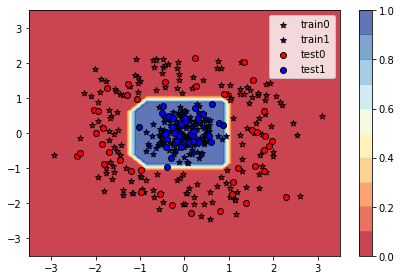

In [41]:
xx, yy = np.meshgrid(np.linspace(-3.5,3.5, 30), np.linspace(-3.5, 3.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
tt=gram(X_grid, X_train,1)
# start plot
plt.figure()
cm = plt.cm.RdYlBu

# plot decision regions
predictions_grid = [svm.predict(tt)]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(0, 1.1, 0.1), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.2, .4,.6,.8,1])

# plot data
plt.scatter(X_train[:, 0][Y_train==0], X_train[:, 1][Y_train==0], c='r', marker='*', edgecolors='k',label='train0')
plt.scatter(X_train[:, 0][Y_train==1], X_train[:, 1][Y_train==1], c='b', marker='*', edgecolors='k',label='train1')

plt.scatter(X_test[:, 0][Y_test==0], X_test[:, 1][Y_test==0], c='r', marker='o', edgecolors='k',label='test0')
plt.scatter(X_test[:, 0][Y_test==1], X_test[:, 1][Y_test==1], c='b', marker='o', edgecolors='k',label='test1')



#plt.ylim(-0.4, 0.4)
#plt.xlim(-0.4, 0.4)
plt.legend()
plt.tight_layout()
plt.show()
